### Sustainability Aware Asset Management: **Groupe A: North America // Scope 1 + 2**
#### **Part I - Standard Asset Allocation**

In [1]:
## Packages lists:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk", font_scale=1.3)
import datetime as dt
from scipy.optimize import minimize

## Importing all the dataframes from data.ipynb
%run data.ipynb

0
595


In [2]:
## Converting into returns using the simple return definition. Also replacing the NaN in the first period by 0.
df_m = monthly_return.pct_change()
monthly_means = df_m.iloc[1:].mean()
df_m.fillna(monthly_means, inplace=True)
df_m.index = pd.to_datetime(df_m.index)

df_y = yearly_return.pct_change()
yearly_means = df_y.iloc[1:].mean()
df_y.fillna(yearly_means, inplace=True)

In [3]:
## DataFrame monthly returns
df_m.head()

,SCHLUMBERGER,ARCH CAP.GP.,EVEREST GROUP,NABORS INDUSTRIES,RENAISSANCERE HDG.,SIGNET JEWELERS,WHITE MOUNTAINS IN.GP.,ARC RESOURCES,AGNICO-EAGLE MNS. (NYS),ALIMENTATION COUCHE TARD,...,WHIRLPOOL,JOHN WILEY AND SONS A,WILLIAMS,WILLIAMS-SONOMA,WOLFSPEED,XCEL ENERGY,XEROX HOLDINGS,YUM! BRANDS,ZEBRA TECHNOLOGIES 'A',ZIONS BANCORP.
2000-01-31,0.009426,0.015105,0.012965,0.012864,0.012923,0.018358,0.012095,0.014740,0.017098,0.021781,...,0.011358,0.007683,0.011675,0.015654,0.015167,0.010854,0.004935,0.015523,0.013134,0.006157
2000-02-29,0.213043,0.042720,-0.024785,0.210970,-0.024188,-0.123221,-0.020000,-0.018121,0.090446,-0.054018,...,-0.061660,-0.050000,0.072112,-0.023672,0.996015,-0.087661,0.041931,-0.069851,0.124601,-0.102536
2000-03-31,0.035756,0.073857,0.331254,0.081883,0.083020,0.065703,0.220886,0.028631,-0.205356,0.017976,...,0.079406,0.265912,0.054242,0.002025,-0.399201,0.131676,0.206472,0.166608,-0.248818,-0.215549
2000-04-30,0.000814,-0.060083,-0.103420,0.016102,-0.098173,0.081647,0.036805,0.035981,-0.033699,0.051096,...,0.110870,-0.041666,-0.146517,0.116935,0.289036,0.116712,0.019246,0.090519,0.139995,-0.003003
2000-05-31,-0.039184,-0.025404,0.162378,0.090333,0.182463,-0.159331,0.015288,0.113836,0.000000,-0.077749,...,-0.125011,0.032612,0.108336,-0.074007,-0.165056,0.014328,0.031131,-0.134621,-0.157894,0.128942


In [4]:
## DataFrame yearly returns
df_y.head()

,SCHLUMBERGER,ARCH CAP.GP.,EVEREST GROUP,NABORS INDUSTRIES,RENAISSANCERE HDG.,SIGNET JEWELERS,WHITE MOUNTAINS IN.GP.,ARC RESOURCES,AGNICO-EAGLE MNS. (NYS),ALIMENTATION COUCHE TARD,...,WHIRLPOOL,JOHN WILEY AND SONS A,WILLIAMS,WILLIAMS-SONOMA,WOLFSPEED,XCEL ENERGY,XEROX HOLDINGS,YUM! BRANDS,ZEBRA TECHNOLOGIES 'A',ZIONS BANCORP.
1999,0.115662,0.197524,0.199058,0.067017,0.156704,0.252760,0.165353,0.185748,0.164554,0.280002,...,0.142114,0.074795,0.222315,0.206473,0.192141,0.131275,0.072407,0.166085,0.165428,0.069183
2000,0.438938,0.188184,2.230862,0.911922,0.978139,-0.280871,1.669779,0.535816,-0.191025,0.020209,...,-0.245418,0.293421,0.325503,-0.565217,-0.167643,0.584829,-0.788674,-0.145666,-0.302620,0.073984
2001,-0.303476,0.716674,-0.008792,-0.419611,0.243833,0.860416,0.090904,0.226762,0.650180,0.929680,...,0.572687,0.080064,-0.289743,1.145000,-0.170870,0.005747,1.271530,0.490935,0.360643,-0.145427
2002,-0.221917,0.210431,-0.213694,0.027383,0.264452,-0.183182,-0.069064,0.127979,0.508185,0.440221,...,-0.272551,0.051227,-0.890114,0.265734,-0.445009,-0.571981,-0.227479,-0.015437,0.032252,-0.239372
2003,0.321163,0.278838,0.537984,0.176638,0.255900,0.757192,0.428426,0.743506,-0.185941,0.608581,...,0.423810,0.094681,2.659272,0.280661,0.081958,0.616905,0.714257,0.420325,0.737415,0.589503


### Part I - Standard Asset Allocation

#### 1.1 - Construction of a minimum variance portfolio

As we are computing the minimum variance portfolio out-of-sample, we use the first 6 years of monthly returns (from Jan. 2000 to Dec. 2005) to compute the vector of expected returns and the covariance matrix

In [5]:
## Sampling the dataframe from Jan. 2000 to Dec. 2005
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2005, 12, 31)
stocks = df_m.columns
sample_m = df_m[df_m.index.isin(pd.date_range(start, end))]

## Checking if tau is equal to 72
tau = len(sample_m)
tau == 72

True

We computed the expected returns as:
$$
\hat{\mu}_{Y+1} = \frac{1}{\tau}\sum_{k=0}^{\tau-1} R_{t-k}
$$

In [6]:
## It is simply a basic mean function.
mu_hat = pd.DataFrame(sample_m.mean(axis=0)).T

The covariance matrix is computed as:
$$
\Sigma_{Y+1} = \frac{1}{\tau}\sum_{k=0}^{\tau-1} (R_{t-k} - \hat{\mu}_{Y+1})'(R_{t-k} - \hat{\mu}_{Y+1})
$$

In [7]:
## We use the parameter bias=True, because we divide the sum by 1/tau instead of 1/(tau-1)
excess_returns = sample_m.subtract(mu_hat.values.squeeze(), axis=1)
covmat = 1/tau * excess_returns.T @ excess_returns

## We control if there is a missing value in our covariance matrix
print(covmat.isnull().values.any())

False


For the allocation, we use the following maximizazion problem, while restricting the optimal weights to be positive:

$$\min_{{{\alpha_{Y}}}}\quad \sigma^{2}_{p,Y+1} = \alpha'_{Y}\Sigma_{Y+1}\alpha_{Y}$$

$$\text{s.t.}\quad \alpha'_{Y}e = 1$$

$$\text{s.t.}\quad  \alpha_{i,Y} \ge 0 \quad \text{for all i}$$

In [8]:
# Define objective function (portfolio variance)
def portfolio_variance(weights, covmat):
    return np.dot(weights.T, np.dot(covmat, weights))

# Define constraint (sum of weights equals 1)
def constraint(weights):
    return np.sum(weights) - 1
    
# Number of assets
n_assets = len(covmat)

# Initial guess for weights
initial_weights = np.ones(n_assets) / n_assets

# Define bounds for weights (0 to 1) long-only portfolio
bounds = [(0, None)] * n_assets

# Perform optimization
result = minimize(portfolio_variance, initial_weights, args=(covmat,), constraints={'type': 'eq', 'fun': constraint}, bounds=bounds)

# Get optimal weights
optimal_weights = result.x

# Print results
weights = pd.DataFrame(optimal_weights, index=covmat.index, columns=['weight'])
weights

,weight
SCHLUMBERGER,0.000000e+00
ARCH CAP.GP.,0.000000e+00
EVEREST GROUP,2.026387e-18
NABORS INDUSTRIES,0.000000e+00
RENAISSANCERE HDG.,1.219385e-02
...,...
XCEL ENERGY,3.498025e-19
XEROX HOLDINGS,1.100723e-18
YUM! BRANDS,5.808223e-04
ZEBRA TECHNOLOGIES 'A',2.075877e-03


In [9]:
## These are the 20 largest weights of the min variance portfolio 2006 using out of sample data: 2000-2005
weights['weight'].nlargest(20)

HERSHEY                    0.080769
SOUTHERN                   0.057619
MEDTRONIC                  0.054424
BLACKROCK                  0.052931
VALHI                      0.041819
PUBLIC STORAGE             0.039619
LOCKHEED MARTIN            0.035474
PROCTER & GAMBLE           0.033998
AGNICO-EAGLE MNS. (NYS)    0.033846
IMPERIAL OIL               0.033091
BOSTON SCIENTIFIC          0.032089
BALL                       0.030862
MARKEL GROUP               0.029572
HUNTINGTON BCSH.           0.029023
IDEXX LABORATORIES         0.028369
RB GLOBAL (NYS)            0.028322
UNITED THERAPEUTICS        0.022599
BCE                        0.021846
VIATRIS                    0.020589
GEN DIGITAL                0.019220
Name: weight, dtype: float64

## Rebalance portfolio from Dec. 2005 to Dec. 2021. (We start to use the rolling windows here)

In [10]:
def roll_min_var_opt(df, start, end):
    stocks = df.columns
    year_weight = end.year + 1
    weights_df = pd.DataFrame(index=stocks)

    for i in range(18):
        ## Resample from start to end
        sample_m = df[df.index.isin(pd.date_range(start, end))]
        tau = len(sample_m)

        ## Compute expected returns
        mu_hat = pd.DataFrame(sample_m.mean(axis=0)).T
    
        ## Excess returns
        excess_returns = sample_m.subtract(mu_hat.values.squeeze(), axis=1)
    
        ## Covariance Matrix
        covmat = 1/tau * excess_returns.T @ excess_returns
    
        # Define objective function (portfolio variance)
        def portfolio_variance(weights, covmat):
            return np.dot(weights.T, np.dot(covmat, weights))
    
        # Define constraint (sum of weights equals 1)
        def constraint(weights):
            return np.sum(weights) - 1
    
        n_assets = len(covmat)
    
        # Initial guess for weights
        initial_weights = np.ones(n_assets) / n_assets
        
        # Define bounds for weights (0 to 1) long-only portfolio
        bounds = [(0, None)] * n_assets
    
        result = minimize(portfolio_variance, initial_weights, args=(covmat,), constraints={'type': 'eq', 'fun': constraint}, bounds=bounds)
    
        optimal_weights = result.x

        weights_df[year_weight] = optimal_weights

        start = dt.datetime(start.year + 1, 1, 1)
        end = dt.datetime(end.year + 1, 1, 1)
        year_weight += 1

    return weights_df

In [11]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2005, 12, 31)

weights_df = roll_min_var_opt(df_m, start, end)

In [12]:
## These are the optimal weights for each year using rolling window 
## (e.g. for 2006, data used is 2000-2005. For 2007, data used is 2001-2006)
weights_df.head()

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
SCHLUMBERGER,0.000000e+00,2.553878e-18,2.023303e-18,2.805777e-19,0.000000e+00,1.208465e-18,0.000000,1.409217e-17,0.000000e+00,1.985693e-18,1.755540e-18,3.277177e-18,0.000000e+00,0.000000,0.000000,3.369771e-18,0.000000e+00,4.002688e-18
ARCH CAP.GP.,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.010143,0.000000e+00,0.000000e+00,2.780385e-18,0.000000e+00,0.000000e+00,3.182660e-18,0.001013,0.001145,0.000000e+00,0.000000e+00,0.000000e+00
EVEREST GROUP,2.026387e-18,0.000000e+00,0.000000e+00,5.056417e-19,4.109678e-19,7.963530e-18,0.000208,0.000000e+00,4.909969e-18,3.121960e-03,0.000000e+00,0.000000e+00,9.010329e-03,0.002662,0.044626,6.702413e-02,2.534687e-02,2.804996e-02
NABORS INDUSTRIES,0.000000e+00,2.549240e-18,0.000000e+00,1.457126e-19,3.816951e-19,3.885951e-18,0.000000,6.884807e-18,2.371563e-18,0.000000e+00,3.227538e-18,1.313765e-19,0.000000e+00,0.000000,0.000000,0.000000e+00,1.546220e-18,8.394149e-18
RENAISSANCERE HDG.,1.219385e-02,1.824573e-02,2.294535e-02,2.284458e-18,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,3.260270e-02,1.938555e-02,3.693503e-03,9.341518e-03,0.003801,0.012310,3.082429e-02,3.846325e-03,9.930474e-03


In [13]:
## Just computing 5 largest of each column
n_largest_per_year = {}  

for year in weights_df.columns:
    # Get the 5 largest values for the column
    n_largest_per_year[year] = weights_df[year].nlargest(5)

In [14]:
## 5 largest weights for each year
n_largest_per_year

{2006: HERSHEY      0.080769
 SOUTHERN     0.057619
 MEDTRONIC    0.054424
 BLACKROCK    0.052931
 VALHI        0.041819
 Name: 2006, dtype: float64,
 2007: HERSHEY            0.066213
 MEDTRONIC          0.045116
 LOCKHEED MARTIN    0.040563
 BLACKROCK          0.039918
 GENERAL MILLS      0.038842
 Name: 2007, dtype: float64,
 2008: BCE              0.056685
 MEDTRONIC        0.053973
 GENERAL MILLS    0.052675
 HERSHEY          0.049359
 STERICYCLE       0.045265
 Name: 2008, dtype: float64,
 2009: MEDTRONIC            0.055181
 WALMART              0.049446
 PPL                  0.046926
 JOHNSON & JOHNSON    0.039326
 STERICYCLE           0.037457
 Name: 2009, dtype: float64,
 2010: WALMART                0.088647
 QUEST DIAGNOSTICS      0.063039
 STRATEGIC EDUCATION    0.061231
 W R BERKLEY            0.059498
 GENERAL MILLS          0.049377
 Name: 2010, dtype: float64,
 2011: WALMART                 0.133318
 HORMEL FOODS            0.080798
 STRATEGIC EDUCATION     0.075028
 Q

In [15]:
## Checking if the first constraint is respected.
weights_df.sum()

2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.0
2022    1.0
2023    1.0
dtype: float64

In [16]:
## Checking if the second constraint is respected.
print('The smallest weight is: ', np.min(weights_df))
print('The highest weight is: ', np.max(weights_df))

The smallest weight is:  0.0
The highest weight is:  0.15300345822319314


## Ex-post performance computation

In [17]:
debut = dt.date(2005,12,31)
fin = dt.date(2022,12,31)

sample_returns = df_m[df_m.index.isin(pd.date_range(debut, fin))]
weights_sample = pd.DataFrame(columns=sample_returns.index, index=sample_returns.columns)

## replace all the weights of December N-1 by the weights in the weights_df
for i in range(weights_sample.shape[1]):
    if weights_sample.columns[i].month == 12:
        weights_sample.iloc[:,i] = weights_df[weights_sample.columns[i].year + 1]

In [18]:
year = 2006
debut1 = dt.date(year, 1,1)
fin1 = dt.date(year, 12, 31)

## Returns of each stock between debut1 and fin1
sample_returns = df_m[df_m.index.isin(pd.date_range(debut1, fin1))].T

## alphas between December Y-1 and November Y
test = weights_sample.iloc[:,weights_sample.columns.year == year].iloc[: , :-1]
test.insert(0, dt.date(year-1,12,31), weights_df[year])

In [19]:
## DataFrame of the alphas
alpha_data = pd.DataFrame()

for x in range(2006,2023):
    year = x
    debut1 = dt.date(year, 1,1)
    fin1 = dt.date(year, 12, 31)

    sample_returns = df_m[df_m.index.isin(pd.date_range(debut1, fin1))].T
    test = weights_sample.iloc[:,weights_sample.columns.year == year].iloc[: , :-1]
    test.insert(0, dt.date(year-1,12,31), weights_df[year])
    
    for j in range(1,12):
        for i in range(595):
            x = sample_returns.iloc[i,j-1] ## STOCK, DATE
            y = test.iloc[:,j-1] @ sample_returns.iloc[:,j-1] ## January 2006 Performance
            previous_a = test.iloc[i,j-1] ## STOCK, DATE
            
            new_a = previous_a * ((1+x)/(1+y))
            test.iloc[i,j] = new_a

    alpha_data = pd.concat([alpha_data, test], axis=1)

alpha_data = alpha_data.T
alpha_data.index = pd.to_datetime(alpha_data.index)
alpha_data = alpha_data.T

In [20]:
## Ex-post performance calculation
debut2 = dt.date(2006,1,1)
fin2 = dt.date(2022,12,31)
returns06_22 = df_m[df_m.index.isin(pd.date_range(debut2, fin2))].T

performances = []

for i in range(returns06_22.shape[1]):
    performance = returns06_22.iloc[:,i] @ alpha_data.iloc[:,i]
    performances.append(performance)

performances = pd.DataFrame(performances, columns=['performance'], index=returns06_22.columns).T

In [21]:
performances

,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
performance,0.030375,0.020039,0.020022,0.013991,-0.017173,-0.004062,0.027875,0.024915,0.005425,0.030418,...,0.080934,-0.054911,0.002177,-0.038832,0.035035,-0.01942,-0.058604,0.067923,0.044778,-0.037976


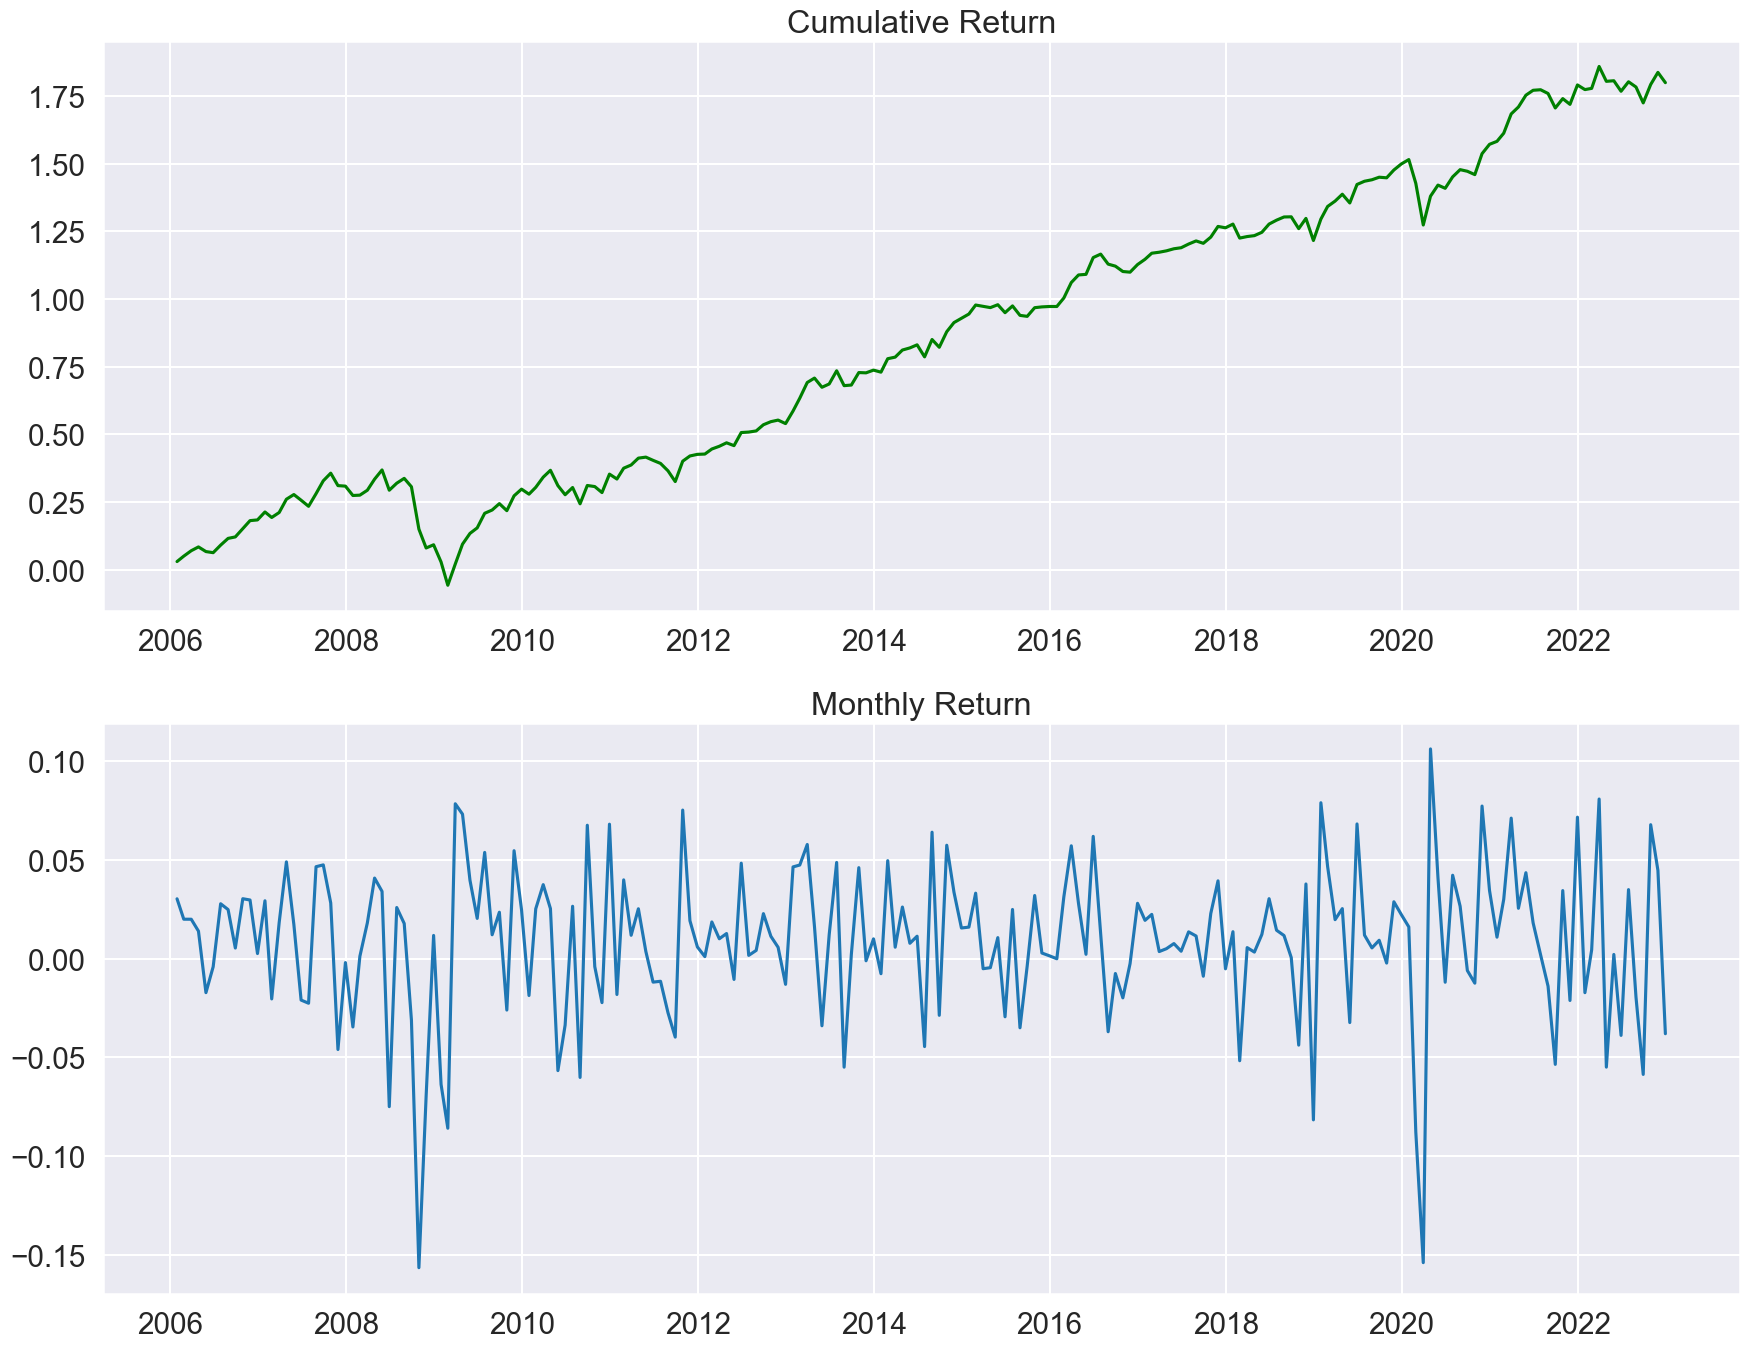

In [22]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(18,14))

ax1.plot(performances.T.cumsum(), color='green')
ax1.title.set_text('Cumulative Return')

ax2.plot(performances.T)
ax2.title.set_text('Monthly Return')

plt.tight_layout()
plt.show()

### Compute the characteristics of this portfolio over the sample: annualized average return ($\bar{\mu}_{p}$), annualized volatility $(\sigma_{p})$, Sharpe ratio $(SR_{p})$, minimum, maximum, and maximum drawdown.

#### Annualized average return $\bar{\mu}_{p}$

$$
\bar{R}_{p}^{(m)} = \frac{1}{T} \sum^{T}_{t=1}R_{p,t}
$$

$$
\bar{R}_{p}^{(y)} = 12 * \bar{R}_{p}^{(m)}
$$

In [23]:
## Ex-post Average Monthly Return
averagereturn_pf = performances.T.mean()

## Annualized Average Return
ann_averagereturn_pf = (12 * averagereturn_pf).values[0]

print('======================================')
print('Annualized Average Return - Portfolio')
print('======================================')
print(f'{ann_averagereturn_pf:.4f}')
print('======================================')

Annualized Average Return - Portfolio
0.1059


#### Annualized volatility $\sigma_{p}$

$$
\sigma_{p}^{(m)} = \sqrt{\frac{1}{T} \sum^{T}_{t=1}(R_{p,t}-\bar{R}_{p}^{(m)})^{2}}
$$

$$
\sigma_{p}^{(y)} = \sqrt{12} * \sigma_{p}^{(m)}
$$

In [24]:
## Ex-post Monthly volatility
sigma_m_pf = (1/len(performances.T) * np.sum(performances.T.subtract(averagereturn_pf) ** 2)) ** (1/2)

## Annualized volatility
sigma_y_pf = (np.sqrt(12) * sigma_m_pf).values[0]

print('===================================')
print('Annualized Volatility - Portfolio')
print('===================================')
print(f'{sigma_y_pf:.5f}')
print('===================================')

Annualized Volatility - Portfolio
0.13171


c:\Users\doren\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


#### Sharpe ratio $SR_{p}$

$$
SR_{p}^{(m)}= \frac{\bar{R}_{p}^{(m)} - R_{f}}{\sigma_{p}^{(m)}}
$$

$$
SR_{p}^{y}= \sqrt{12} * SR_{p}^{(m)}
$$

In [25]:
## Monthly risk-free rate
rf = risk_free/100
rf = rf[rf.index.isin(performances.columns)]

## pas trop sûr de cette formule, à voir avec le prof.
## 1. Est-ce qu'il faut prendre le monthly return - le monthly risk free rate?
## 2. Est-ce que 0.72 paraît correct?

sharpe_m_pf = (performances.subtract(rf.values.squeeze(), axis=1).mean()/sigma_m_pf.values[0]).mean()

sharpe_y_pf = (np.sqrt(12) * sharpe_m_pf)

print('====================================')
print('Annualized Sharpe Ratio - Portfolio')
print('====================================')
print(f'{sharpe_y_pf:.5f}')
print('====================================')

Annualized Sharpe Ratio - Portfolio
0.72352


#### Minimum and maximum

In [26]:
minimum_pf = np.min(performances)
maximum_pf = np.max(performances)

print('=============================')
print('**** Minimum and maximum ****')
print('=============================')
print(f'Minimum: {minimum_pf:.4f}')
print(f'Maximum: {maximum_pf:.4f}')
print('=============================')

**** Minimum and maximum ****
Minimum: -0.1565
Maximum: 0.1063


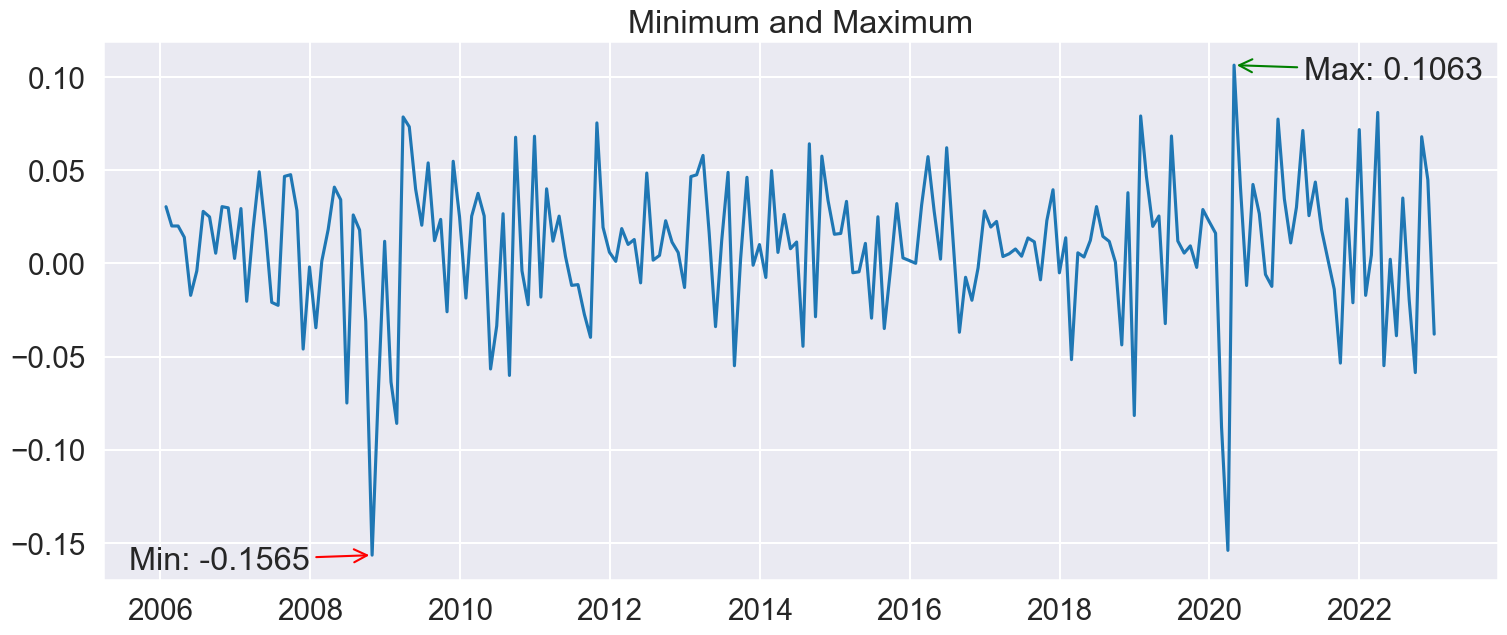

In [27]:
fig, ax = plt.subplots(figsize=(18,7))
ax.plot(performances.T)

## Maximum Value
max_index = performances.stack().idxmax()
max_value = performances.loc[max_index[0], max_index[1]]
ax.annotate(f'Max: {max_value:.4f}', xy=(max_index[1], max_value),
            xytext=(50, -10), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='green'))

## Minimum Value
min_index = performances.stack().idxmin()
min_value = performances.loc[min_index[0], min_index[1]]
ax.annotate(f'Min: {min_value:.4f}', xy=(min_index[1], min_value),
            xytext=(-175, -10), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='red'))

ax.title.set_text('Minimum and Maximum')
plt.show()

#### Maximum drawdown

In [28]:
def max_drawdown(returns):
    cum_ret = (1+returns).cumprod()
    peaks = cum_ret.cummax()
    drawdowns = (cum_ret - peaks) / peaks
    return drawdowns.min().values[0]

MDD_pf = max_drawdown(performances.T)

print("----------------------------")
print("Maximum Drawdown - Portfolio")
print("============================")
print(f'Maximum Drawdown: {MDD_pf:.5f}')
print("----------------------------")

----------------------------
Maximum Drawdown - Portfolio
Maximum Drawdown: -0.36387
----------------------------


#### 1.2 - Comparison with the benchmark, the value-weighted portfolio $P^{(vw)}$

$$
R_{t+1}^{(vw)} = \sum^{N}_{i=1}w_{i,t}R_{i,t+1}
$$

$$
w_{i,t} = \frac{Cap_{i,t}}{\sum^{N}_{j=1}Cap_{j,t}}
$$

In [29]:
## Total Market Cap of All Stocks
mvdf = mv.copy()
totalcap = mvdf.sum()

## Weights of each stock using the second formula
mv_weights = mvdf.div(totalcap)

## Resampling both from 2006 to 2022.
debut_weights = dt.date(2005,12,31)
fin_weights = dt.date(2022,11,30)

debut_returns = dt.date(2006,1,1)
fin_returns = dt.date(2022,12,31)


mv_ret = df_m[df_m.index.isin(pd.date_range(debut_returns, fin_returns))].T
mv_weights = mv_weights.T[mv_weights.T.index.isin(pd.date_range(debut_weights, fin_weights))].T

In [30]:
mv_perf = []

for i in range(mv_ret.shape[1]):
    x = mv_weights.iloc[:,i] @ mv_ret.iloc[:,i]
    mv_perf.append(x)

mv_perf = pd.DataFrame(mv_perf, index=mv_ret.columns, columns=['Return'])

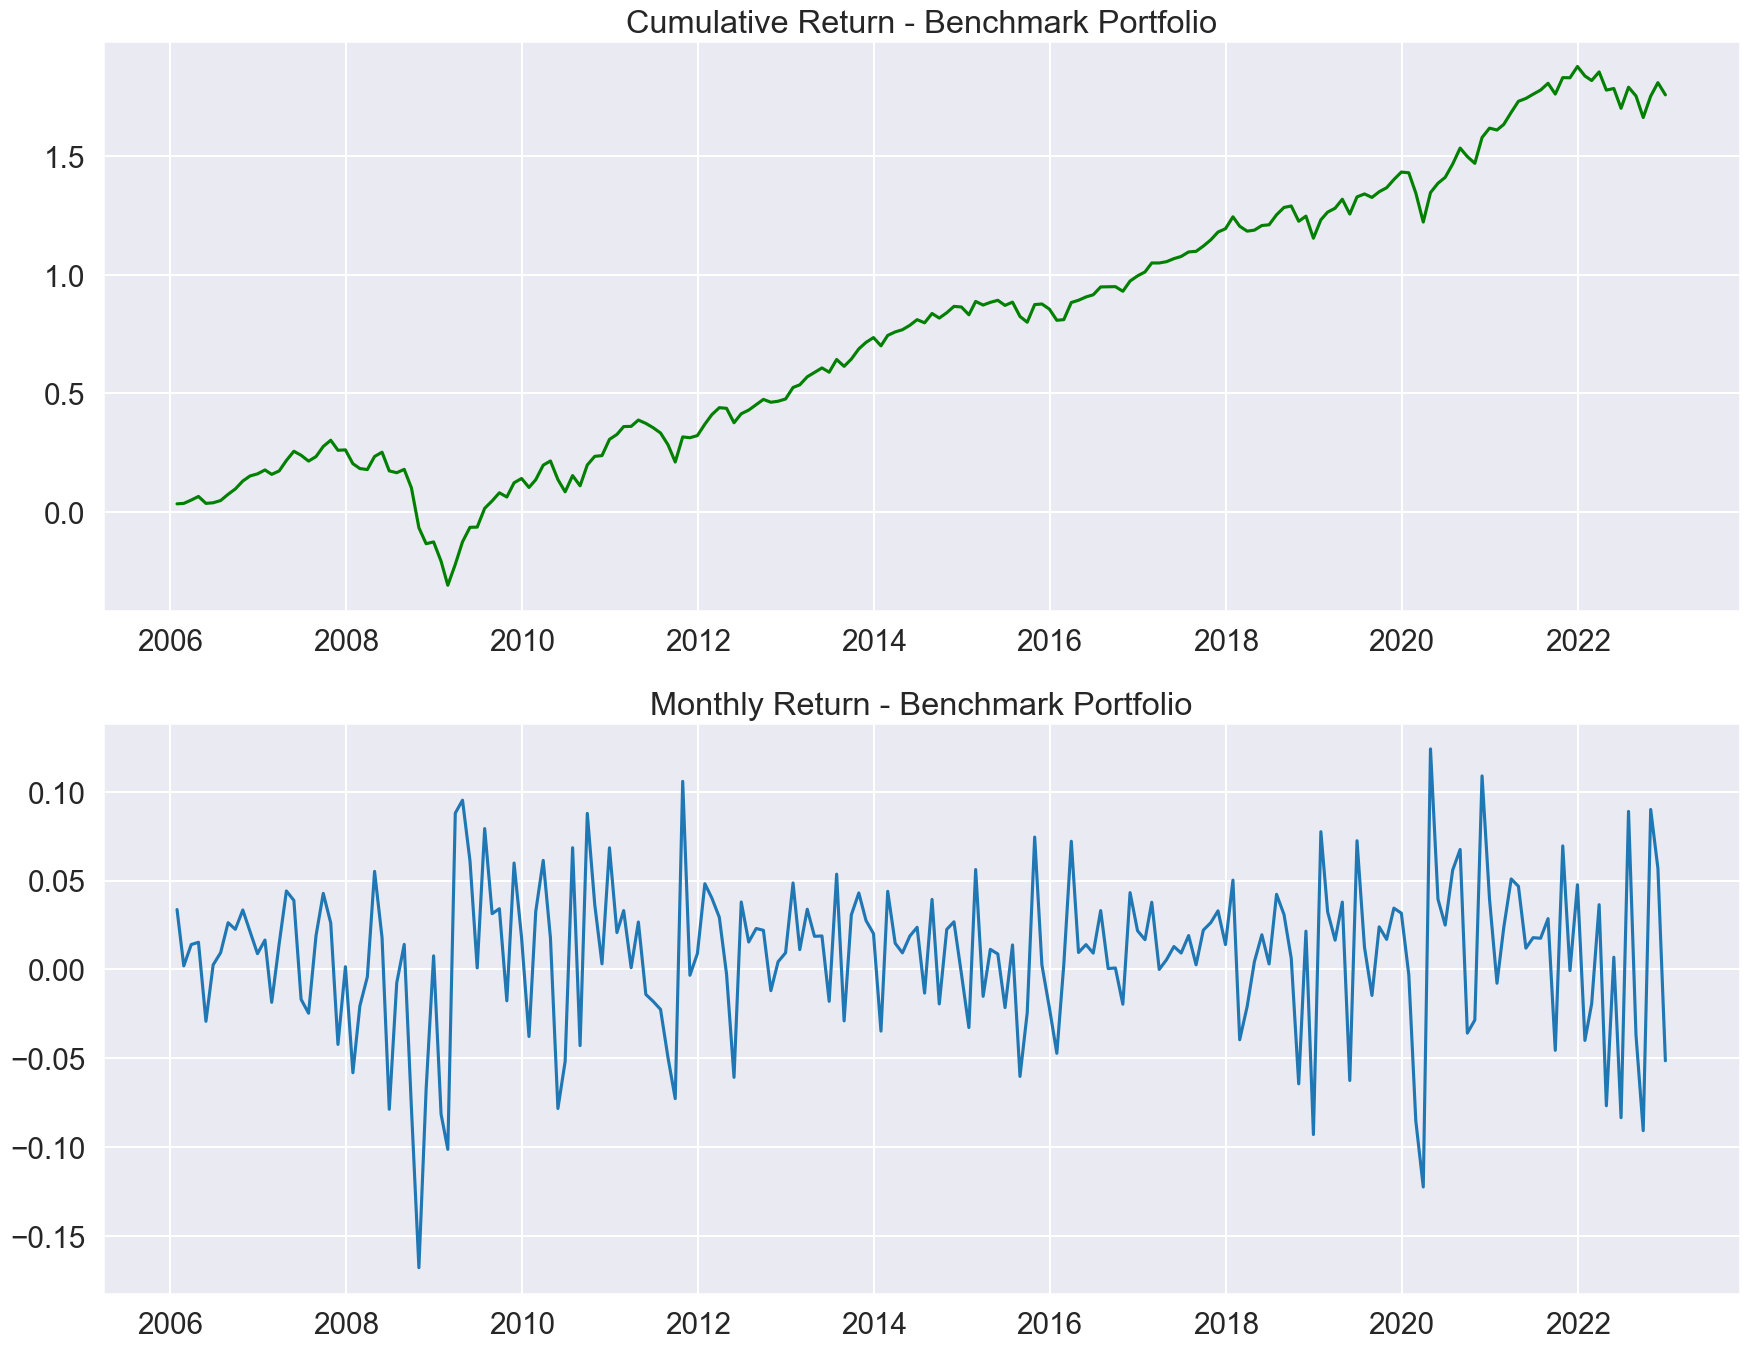

In [31]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(18,14))

ax1.plot(mv_perf.cumsum(), color='green')
ax1.title.set_text('Cumulative Return - Benchmark Portfolio')

ax2.plot(mv_perf)
ax2.title.set_text('Monthly Return - Benchmark Portfolio')

plt.tight_layout()
plt.show()

#### Annualized average return $\bar{\mu}_{p}$

In [32]:
## Average Monthly Return
averagereturn_ben = 1/len(mv_perf) * mv_perf.sum()

## Annualized Average Return
ann_averagereturn_ben = (12 * averagereturn_ben).values[0]
print('======================================')
print('Annualized Average Return - Benchmark')
print('======================================')
print(f'{ann_averagereturn_ben:.4f}')
print('======================================')

Annualized Average Return - Benchmark
0.1035


#### Annualized volatility $\sigma_{p}$

In [33]:
## Ex-post Monthly volatility
sigma_m_ben = (1/len(mv_perf) * np.sum(mv_perf.subtract(averagereturn_ben) ** 2)) ** (1/2)

## Annualized volatility
sigma_y_ben = (np.sqrt(12) * sigma_m_ben).values[0]

print('===================================')
print('Annualized Volatility - Benchmark')
print('===================================')
print(f'{sigma_y_ben:.5f}')
print('===================================')

Annualized Volatility - Benchmark
0.15219


c:\Users\doren\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


#### Sharpe ratio $SR_{p}$

In [34]:
sharpe_m_ben = (mv_perf.T.subtract(rf.values.squeeze(), axis=1).mean()/sigma_m_pf.values[0]).mean()

sharpe_y_ben = (np.sqrt(12) * sharpe_m_ben)

print('====================================')
print('Annualized Sharpe Ratio - Benchmark')
print('====================================')
print(f'{sharpe_y_ben:.5f}')
print('====================================')

Annualized Sharpe Ratio - Benchmark
0.70543


#### Minimum and maximum

In [35]:
minimum_ben = np.min(mv_perf)
maximum_ben = np.max(mv_perf)

print('=============================')
print('**** Minimum and maximum ****')
print('=============================')
print(f'Minimum: {minimum_ben:.4f}')
print(f'Maximum: {maximum_ben:.4f}')
print('=============================')

**** Minimum and maximum ****
Minimum: -0.1680
Maximum: 0.1242


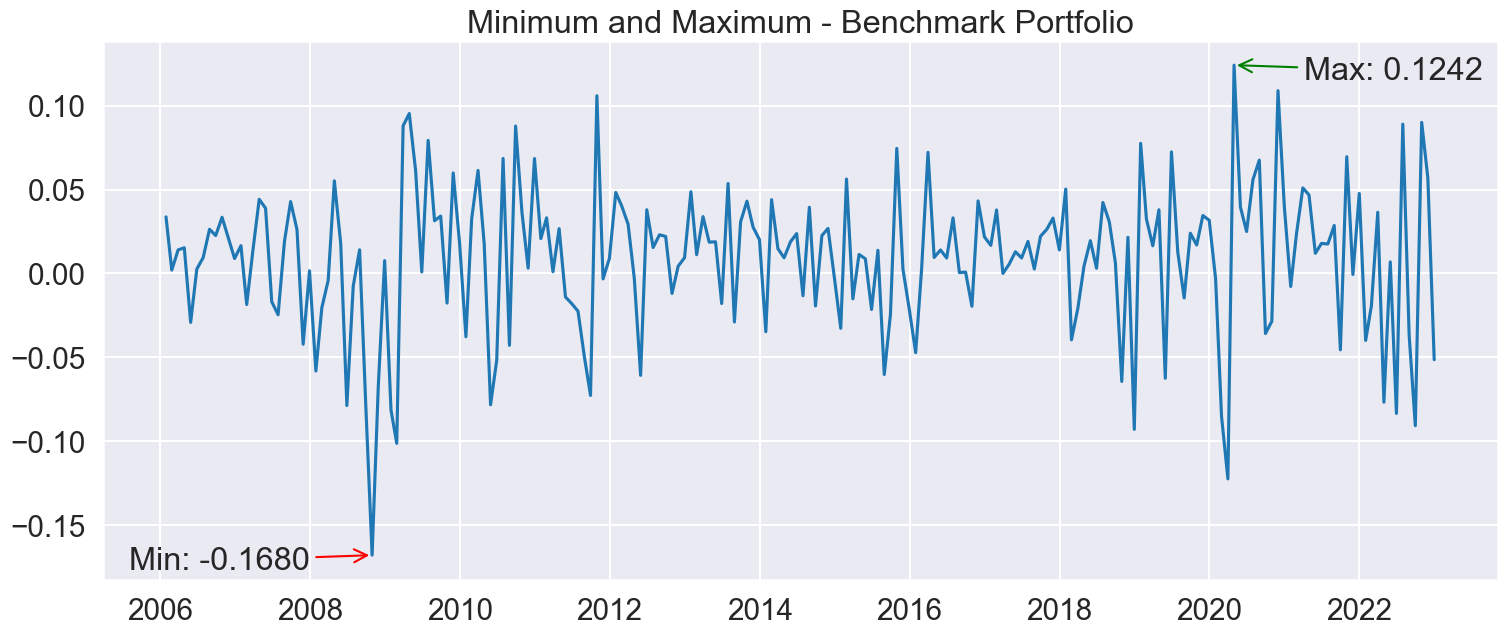

In [36]:
fig, ax = plt.subplots(figsize=(18,7))
ax.plot(mv_perf)

## Maximum Value
max_index = mv_perf.T.stack().idxmax()
max_value = mv_perf.T.loc[max_index[0], max_index[1]]
ax.annotate(f'Max: {max_value:.4f}', xy=(max_index[1], max_value),
            xytext=(50, -10), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='green'))

## Minimum Value
min_index = mv_perf.T.stack().idxmin()
min_value = mv_perf.T.loc[min_index[0], min_index[1]]
ax.annotate(f'Min: {min_value:.4f}', xy=(min_index[1], min_value),
            xytext=(-175, -10), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='red'))

ax.title.set_text('Minimum and Maximum - Benchmark Portfolio')
plt.show()

#### Maximum drawdown

In [37]:
MDD_ben = max_drawdown(mv_perf)
print("----------------------------")
print("Maximum drawdown - Benchmark")
print("============================")
print(f'Maximum Drawdown: {MDD_ben:.5f}')
print("----------------------------")

----------------------------
Maximum drawdown - Benchmark
Maximum Drawdown: -0.47814
----------------------------


#### Comparison between Portfolio and Benchmark

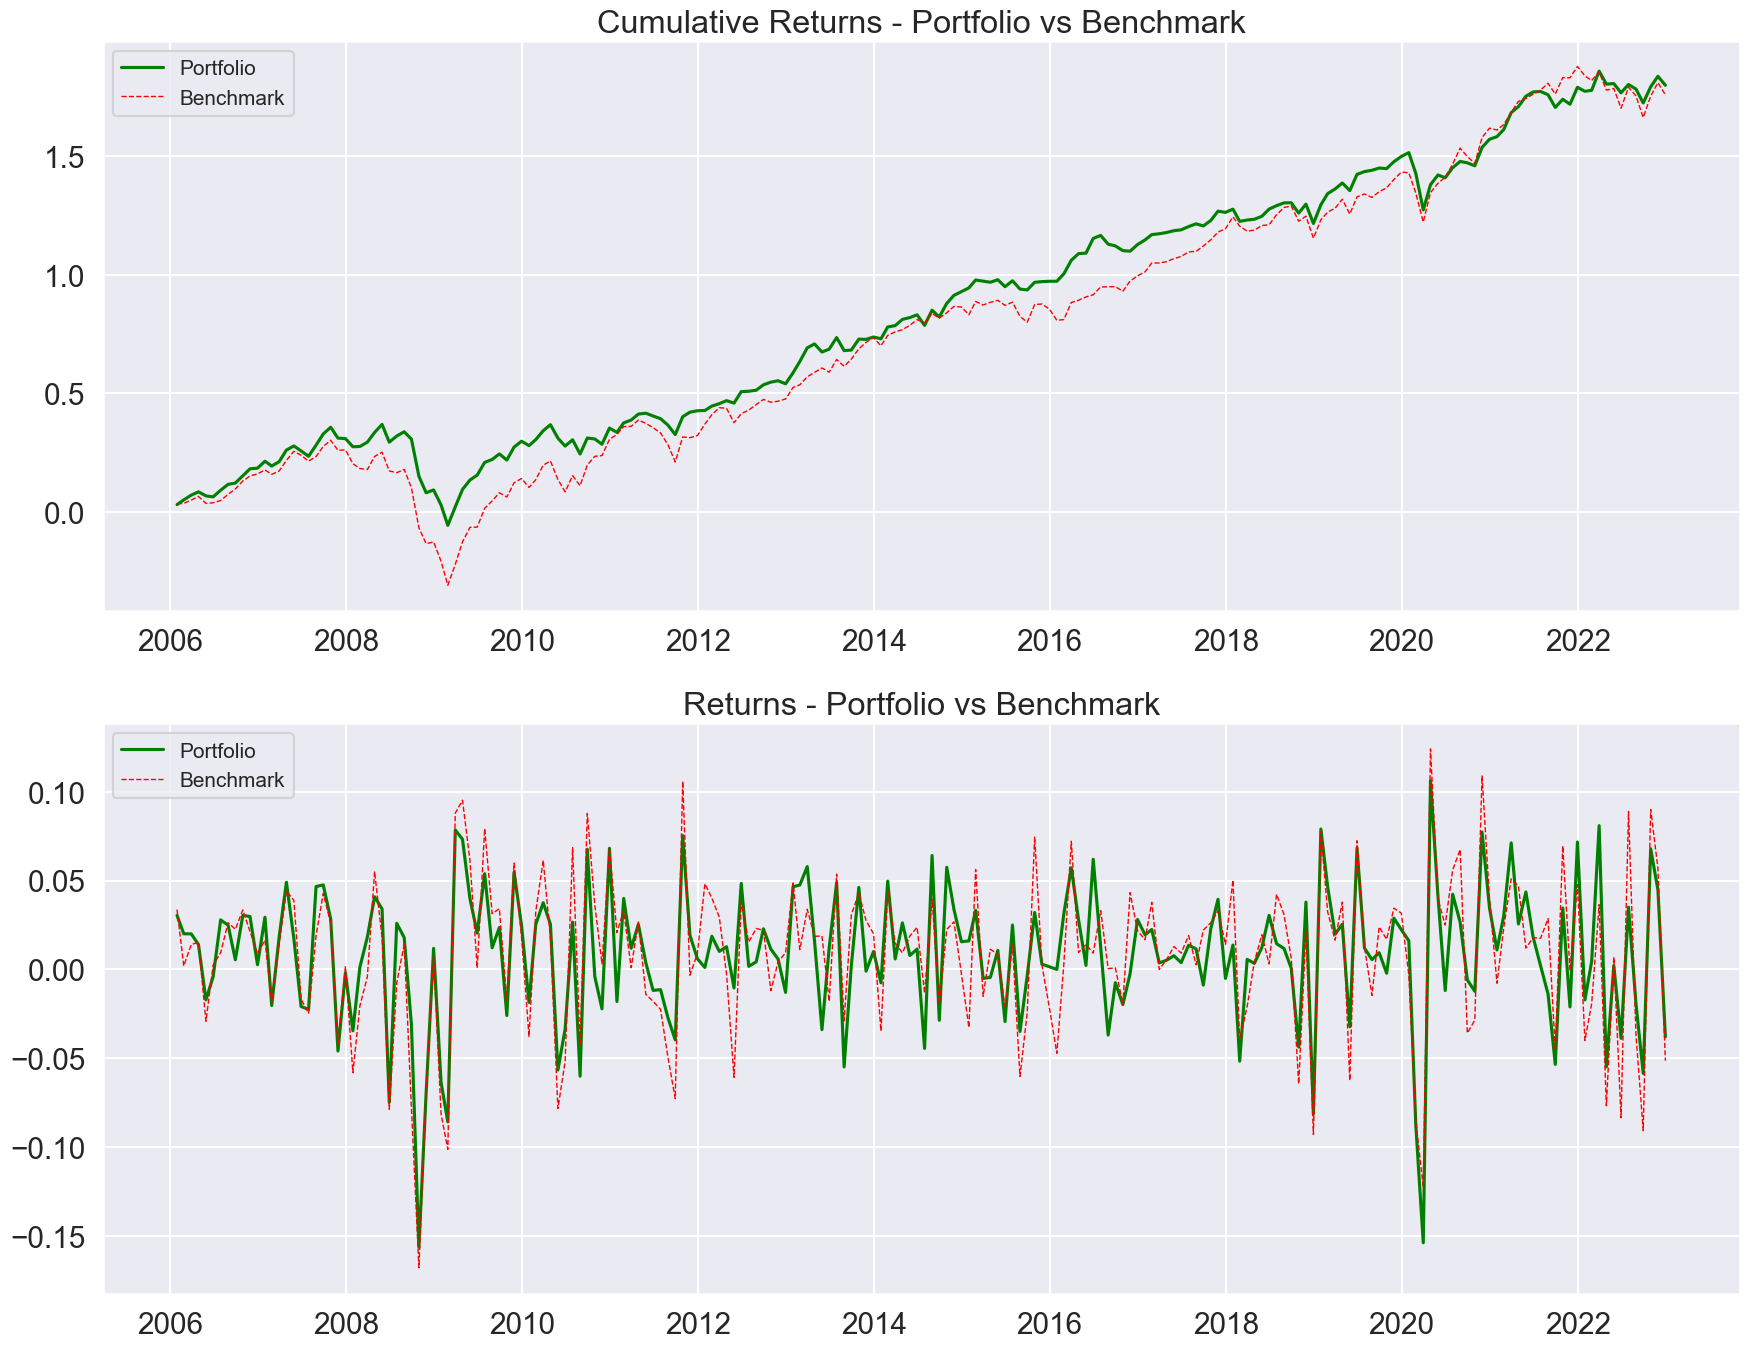

In [38]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(18,14))

ax1.title.set_text('Cumulative Returns - Portfolio vs Benchmark')
ax1.plot(performances.T.cumsum(), color='green', label="Portfolio")
ax1.plot(mv_perf.cumsum(), color='red', label="Benchmark", lw = 1, linestyle='--')
ax1.legend(prop = { "size": 15 })

ax2.title.set_text('Returns - Portfolio vs Benchmark')
ax2.plot(performances.T, color='green', label="Portfolio")
ax2.plot(mv_perf, color='red', label="Benchmark", lw = 1, linestyle='--')
ax2.legend(prop = { "size": 15 }, loc ="upper left")

plt.tight_layout()
plt.show()

In [39]:
## Creating a Table with the Characteristic of both portfolios to compare them

comparative = pd.DataFrame(columns=['Portfolio', 'Benchmark'],
                           index=['Annualized Average Return', 'Annualized Volatility', 'Sharpe Ratio',
                                  'Minimum', 'Maximum', 'Maximum Drawdown'])


comparative.loc['Annualized Average Return', 'Portfolio'] = ann_averagereturn_pf
comparative.loc['Annualized Volatility', 'Portfolio'] = sigma_y_pf
comparative.loc['Sharpe Ratio', 'Portfolio'] = sharpe_y_pf
comparative.loc['Minimum', 'Portfolio'] = minimum_pf
comparative.loc['Maximum', 'Portfolio'] = maximum_pf
comparative.loc['Maximum Drawdown', 'Portfolio'] = MDD_pf

comparative.loc['Annualized Average Return', 'Benchmark']= ann_averagereturn_ben
comparative.loc['Annualized Volatility', 'Benchmark'] = sigma_y_ben
comparative.loc['Sharpe Ratio', 'Benchmark'] = sharpe_y_ben
comparative.loc['Minimum', 'Benchmark'] = minimum_ben
comparative.loc['Maximum', 'Benchmark'] = maximum_ben
comparative.loc['Maximum Drawdown', 'Benchmark'] = MDD_ben

comparative

,Portfolio,Benchmark
Annualized Average Return,0.105873,0.103492
Annualized Volatility,0.131705,0.15219
Sharpe Ratio,0.723517,0.705435
Minimum,-0.156537,-0.168004
Maximum,0.106319,0.124161
Maximum Drawdown,-0.36387,-0.478136


#### **Part 2 - Asset Allocation with a Carbon Emissions Reduction**

##### 2. Allocation with a 50% Reduction in Carbon Emissions

In [40]:
scope1_int = pd.read_excel('Data/TC_Scope1Intensity.xlsx', index_col=0)
scope1_int = scope1_int[scope1_int.index.isin(companies.index)].reset_index().set_index('NAME')
scope1_int = scope1_int.iloc[:,7:]

scope1_em = pd.read_excel('Data/TC_Scope1.xlsx', index_col=0)
scope1_em = scope1_em[scope1_em.index.isin(companies.index)].reset_index().set_index('NAME')
scope1_em = scope1_em.iloc[:,7:]

scope2_int = pd.read_excel('Data/TC_Scope2Intensity.xlsx', index_col=0)
scope2_int = scope2_int[scope2_int.index.isin(companies.index)].reset_index().set_index('NAME')
scope2_int = scope2_int.iloc[:,7:]

scope2_em = pd.read_excel('Data/TC_Scope2.xlsx', index_col=0)
scope2_em = scope2_em[scope2_em.index.isin(companies.index)].reset_index().set_index('NAME')
scope2_em = scope2_em.iloc[:,7:]

carbon_em = scope2_em + scope1_em
carbon_int = scope2_int + scope1_int

2.1 We compute the weighted average carbon intensity and the carbon footprint:

$$
WACI^{(P)}_{Y} = \sum^{N}_{i=1}\alpha_{i,Y}CI_{i,Y}
$$

$$
CF_{Y}^{(p)} = \sum^{N}_{i=1} o_{i,Y} E_{i,Y}
$$

In [194]:
## WACI
weights2006_2021 = weights_df.iloc[:,weights_df.columns.isin(range(2006,2021+1))]
carbonint2006_2021 = carbon_int.iloc[:,carbon_int.columns.isin(range(2006,2021+1))]

waci = pd.DataFrame(index=['Carbon Intensity'], columns=carbonint2006_2021.columns)


for i in range(np.shape(weights2006_2021)[1]):
    waci.iloc[:,i] = (weights2006_2021.iloc[:,i] * carbonint2006_2021.iloc[:,i]).sum()

waci.T

,Carbon Intensity
2006,705.735549
2007,428.309843
2008,598.412246
2009,596.953566
2010,488.181734
2011,169.603977
2012,308.501725
2013,604.906671
2014,462.996291
2015,713.897645


In [208]:
## Carbon Footprint
'''
Question to ask the professor:
    * Is this correct to use the weights for the year Y with the carbon emissions for the year Y, how do we need to use the weights for the year Y with the carbon emission for the year Y-1?
    * Is this also correct to compute x (the cumulative return of our portfolio) to find the v_{Y} variable?
'''

## Compute the V_{Y} (Dollar value of the Portfolio at year Y)
initial_invest = 1_000_000
vy = pd.DataFrame(index=range(2006,2021+1), columns=['Portfolio Value (in $)'])
x = (1+performances.T).cumprod() * initial_invest

for year in range(2006, 2021+1):
    vy.loc[year] = x[x.index.year == year].iloc[-1,:].values[0]

## Compute the V_{i,Y} (Dollar value invested in firm i at year Y)
viy = pd.DataFrame(index=range(2006,2021+1), columns=mv_y.index)

for year in range(2006, 2021+1):
    viy.loc[year] = vy.loc[year].values[0] * weights2006_2021[year]

## Compute o_{i,Y} (Measure of the fraction of the equity of the firm owned by the portfolio)
oiy = (viy.T / mv_y.iloc[:,mv_y.columns.isin(range(2006, 2021+1))]).T

## Compute the Carbon Footprint of the Portfolio at year Y
cfy = pd.DataFrame(index=range(2006,2021+1), columns=['Carbon Footprint'])

for year in range(2006, 2022):
    cfy.loc[year] = 1/vy.loc[year].values[0] * (oi.loc[year] * carbon_em[year]).sum()

cfy

,Carbon Footprint
2006,372.927066
2007,231.97157
2008,488.436189
2009,396.866223
2010,306.23067
2011,154.49064
2012,219.627154
2013,344.243701
2014,242.804515
2015,415.499071


#### 2.2 Optimal long-only portfolio with a carbon footprint 50% below the carbon footprint of the optimal long-only portfolio $P^{(mv)}_{oos}$ determined in point 1.2

In [209]:
mv.columns = pd.to_datetime(mv.columns)

'''
Question to ask the professor:
    * Is this correct to do so to compute the carbon footprint starting with the weights?
    * Is there a more efficient way?
'''

def carbon_footprint(weights, initial_invest, year):
    '''
    Function to compute the carbon footprint of our portfolio of the year Y.
    Inputs:
    * The weights,
    * The initial investment (in $)
    * The year Y
    '''
    returns_year = df_m[df_m.index.year == year].T
    ## Alphas
    alpha_data = pd.DataFrame(index=pd.date_range(dt.date(year-1, 12, 31), dt.date(year, 11, 30)), columns=df_m.columns.values)
    alpha_data.index = pd.to_datetime(alpha_data.index)
    alpha_data = alpha_data.resample('M').last().T
    alpha_data.iloc[:,0] = weights

    for date in range(1, 12):
        for stock in range(595):
            stock_ret = returns_year.iloc[stock, date-1]
            pf_ret = alpha_data.iloc[:, date-1] @ returns_year.iloc[:, date-1]
            previous_alpha = alpha_data.iloc[stock, date-1]
            alpha_data.iloc[stock, date] = previous_alpha * ((1 + stock_ret) / (1 + pf_ret))
    
    ## Ex-post performance calculation
    performances = pd.DataFrame(index=returns_year.index, columns=returns_year.columns)
    for i in range(12):
        performances.iloc[:,i] = alpha_data.iloc[:,i] * returns_year.iloc[:,i]
    
    performances = performances.sum()

    ## Portfolio Value (need to pass the new value to the next forloop)
    vy = ((1+performances).cumprod() * initial_invest).iloc[-1]

    ## Market Cap
    market_cap = mv.loc[:, mv.columns.year == year].iloc[:,-1]

    ## ViY
    viy = weights * vy

    ## Oi
    oi = viy/market_cap

    ## CFy
    cfy = 1/vy * (oi* carbon_em[year]).sum()

    ## return CFI
    return cfy

$$
\min_{\alpha_{Y}} \quad \sigma^2_{p,Y} = \alpha'_Y\Sigma_{Y+1}\alpha_Y\\


s.t.\quad CF_Y^{(p)} \le 0.5 \times  CF_Y^{(P_{oos}^{(mv)})}\\


s.t.\quad \alpha_{i,Y} \ge 0 \quad \quad \text{for all i}
$$

In [44]:
'''
Question to ask the professor:
    * Is it normal that it takes that much time to optimize ? (3 hours and still no result)
'''

def portfolio_variance(weights, covmat):
    '''
    Compute the portfolio variance given the weights and the covmat.
    '''
    return np.dot(weights.T, np.dot(covmat, weights))

def constraint(weights):
    '''
    Full investment constraint.
    '''
    return np.sum(weights) - 1

def carbon_constraint(weights, initial_invest, year, target_cf):
    '''
    Constraint that the carbon footprint is less or equal than 0.5 * target.
    '''
    return -(carbon_footprint(weights, initial_invest, year) - 0.5 * target_cf)

initial_invest = 1_000_000
year = 2006
target_cf = cfy.loc[year].values[0]

## Make the sample
start = dt.date(year-6, 1, 31)
end = dt.date(year-1, 12, 31)
sample = df_m[df_m.index.isin(pd.date_range(start, end))]

## Compute expected & excess returns
mu_hat = pd.DataFrame(sample.mean(axis=0)).T
excess_returns = sample.subtract(mu_hat.values.squeeze(), axis=1)

## Covariance Matrix
tau = len(sample)
covmat = 1/tau * excess_returns.T @ excess_returns

# Number of assets
n_assets = len(covmat)

# Initial guess for weights
weights = np.ones(n_assets) / n_assets
weights = pd.Series(weights, index=df_m.columns)
weights.name = year

# Define bounds for weights (0 to 1) long-only portfolio
bounds = [(0, 1)] * n_assets

# Perform optimization
result = minimize(portfolio_variance, weights, args=(covmat,), constraints=[
    {'type': 'eq', 'fun': constraint},
    {'type': 'ineq', 'fun': carbon_constraint, 'args': (initial_invest, year, target_cf)}
], bounds=bounds)

# Get optimal weights
optimal_weights = result.x


KeyboardInterrupt: 